# Análise Exploratória, Pré-processamento e Clusterização


In [1]:
# Importações e utilitários
import sys, os
import importlib
deps = ['numpy','pandas','scipy','matplotlib','seaborn','sklearn','statsmodels']
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Tenta importar o fator de inflação de variância (VIF) do statsmodels; se falhar, define como None
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except Exception:
    variance_inflation_factor = None

# Detecta automaticamente a coluna que representa o país, procurando por nomes comuns ou alta cardinalidade
def detect_country_column(df: pd.DataFrame):
    for name in ['country']:
        if name in df.columns:
            return name
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    if not obj_cols:
        return None
    n = len(df)
    best, best_ratio = None, 0.0
    for c in obj_cols:
        ratio = df[c].nunique(dropna=True) / max(n,1)
        if ratio > best_ratio:
            best_ratio, best = ratio, c
    return best

# Calcula estatísticas descritivas e detecta outliers (IQR e z-score) para cada coluna numérica
def compute_stats(df: pd.DataFrame, num_cols):
    rows = []
    for col in num_cols:
        s = df[col].dropna()
        if s.empty:
            rows.append({'variable': col, 'count': int(df[col].count()), 'min': np.nan, 'max': np.nan,
                         'range': np.nan, 'mean': np.nan, 'median': np.nan, 'std': np.nan, 'skew': np.nan,
                         'kurtosis': np.nan, 'q1': np.nan, 'q3': np.nan, 'iqr': np.nan,
                         'outliers_iqr': 0, 'outliers_zscore': 0, 'missing_fraction': float(df[col].isna().mean())})
            continue
        q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
        lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
        out_iqr = int(((s < lower) | (s > upper)).sum())
        z = np.abs(stats.zscore(s, nan_policy='omit')); out_z = int((z > 3).sum()) if isinstance(z, np.ndarray) else 0
        rows.append({'variable': col, 'count': int(s.count()), 'min': float(s.min()), 'max': float(s.max()),
                     'range': float(s.max() - s.min()), 'mean': float(s.mean()), 'median': float(s.median()),
                     'std': float(s.std(ddof=1)), 'skew': float(stats.skew(s, nan_policy='omit')),
                     'kurtosis': float(stats.kurtosis(s, nan_policy='omit')), 'q1': float(q1), 'q3': float(q3),
                     'iqr': float(iqr), 'outliers_iqr': out_iqr, 'outliers_zscore': out_z,
                     'missing_fraction': float(df[col].isna().mean())})
    return pd.DataFrame(rows)

# Decide entre escalonador Standard ou Robust baseado na proporção de outliers ou assimetria
def decide_scaler(stats_df: pd.DataFrame):
    outlier_cols = (stats_df['outliers_iqr'] > 0) | (stats_df['outliers_zscore'] > 0)
    skew_high = stats_df['skew'].abs() > 1
    if outlier_cols.sum() >= max(1, len(stats_df)//3) or skew_high.sum() >= max(1, len(stats_df)//3):
        return 'robust'
    return 'standard'

# Aplica winsorização (clip) nos valores extremos usando limites do IQR para reduzir influência de outliers
def winsorize_iqr(df: pd.DataFrame, num_cols):
    df_w = df.copy()
    for col in num_cols:
        s = df_w[col]
        if s.isna().all():
            continue
        q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
        lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
        df_w[col] = s.clip(lower, upper)
    return df_w

# Calcula o VIF para avaliar multicolinearidade entre variáveis numéricas (requer statsmodels)
def compute_vif(df: pd.DataFrame, num_cols):
    if variance_inflation_factor is None or len(num_cols) < 2:
        return None
    X = df[num_cols].copy()
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    res = []
    for i in range(len(num_cols)):
        vif = float(variance_inflation_factor(X_imputed, i))
        res.append({'variable': num_cols[i], 'VIF': vif})
    return pd.DataFrame(res)


In [2]:
# Carregar dataset
data_path = os.path.join(os.path.dirname(os.getcwd()), 'Clusterização', 'Country-data.csv') if not os.path.exists('Country-data.csv') else 'Country-data.csv'
df = pd.read_csv(data_path)
print('Shape:', df.shape)
df.head()


Shape: (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# Número total de países distintos
country_col = detect_country_column(df)
if country_col is None:
    print('Coluna de país não detectada explicitamente; prosseguindo sem contagem.')
    country_count = None
else:
    country_count = int(df[country_col].nunique(dropna=True))
    print(f'Total de países distintos: {country_count} (coluna: {country_col})')


Total de países distintos: 167 (coluna: country)


In [4]:
# Variáveis numéricas e categóricas (restritas ao dicionário)
if 'expected_numeric' in globals():
    num_cols = [c for c in expected_numeric if c in df.columns]
else:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','string']).columns.tolist()
if country_col and country_col in cat_cols:
    cat_cols = [c for c in cat_cols if c != country_col]
print('Numéricas (dicionário):', num_cols)
print('Categóricas (excluindo país):', cat_cols)


Numéricas (dicionário): ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
Categóricas (excluindo país): []


In [5]:
# Estatísticas descritivas e classificação de distribuição
stats_df = compute_stats(df, num_cols)
# Classificação da distribuição: usando skewness/kurtosis e teste de normalidade (D'Agostino)
def classify_distribution(row):
    s = df[row['variable']].dropna()
    try:
        k2, p = stats.normaltest(s)
    except Exception:
        p = np.nan
    skew = row['skew']
    if not np.isnan(p) and p > 0.05 and abs(skew) < 0.5:
        return 'aprox. normal'
    if skew > 1:
        return 'assimétrica à direita'
    if skew < -1:
        return 'assimétrica à esquerda'
    return 'levemente assimétrica/mesocúrtica'

stats_df['distribuicao'] = stats_df.apply(classify_distribution, axis=1)
stats_df['necessita_escalonamento'] = ((stats_df['skew'].abs() > 0.5) | (stats_df['outliers_iqr'] > 0) | (stats_df['outliers_zscore'] > 0))
stats_df[['variable','min','max','range','outliers_iqr','outliers_zscore','skew','kurtosis','distribuicao','necessita_escalonamento']].round(4)


,variable,min,max,range,outliers_iqr,outliers_zscore,skew,kurtosis,distribuicao,necessita_escalonamento
0,child_mort,2.6000,208.00,205.4000,4,2,1.4377,1.6787,assimétrica à direita,True
1,exports,0.1090,200.00,199.8910,5,3,2.4238,9.8019,assimétrica à direita,True
2,health,1.8100,17.90,16.0900,2,1,0.6994,0.6379,levemente assimétrica/mesocúrtica,True
3,imports,0.0659,174.00,173.9341,4,3,1.8881,6.5196,assimétrica à direita,True
4,income,609.0000,125000.00,124391.0000,8,4,2.2114,6.7843,assimétrica à direita,True
5,inflation,-4.2100,104.00,108.2100,5,2,5.1076,40.4674,assimétrica à direita,True
6,life_expec,32.1000,82.80,50.7000,3,1,-0.9623,1.0817,levemente assimétrica/mesocúrtica,True
7,total_fer,1.1500,7.49,6.3400,1,1,0.9584,-0.2169,levemente assimétrica/mesocúrtica,True
8,gdpp,231.0000,105000.00,104769.0000,25,4,2.1981,5.3281,assimétrica à direita,True


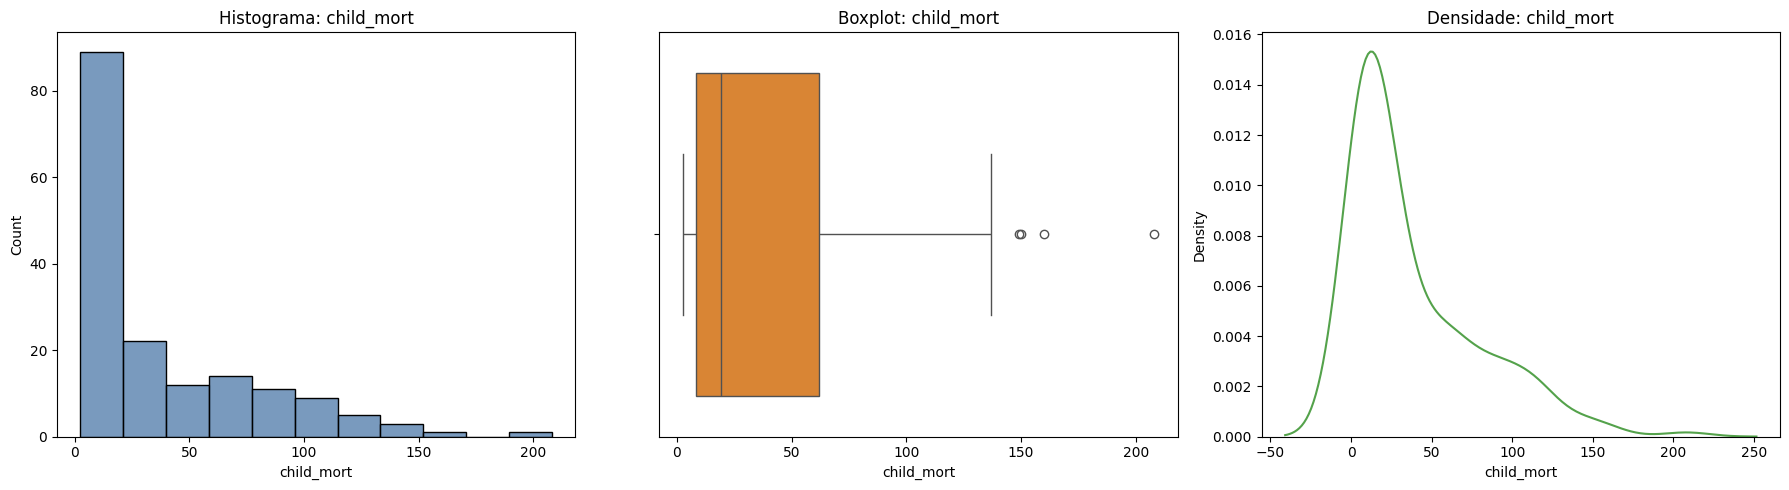

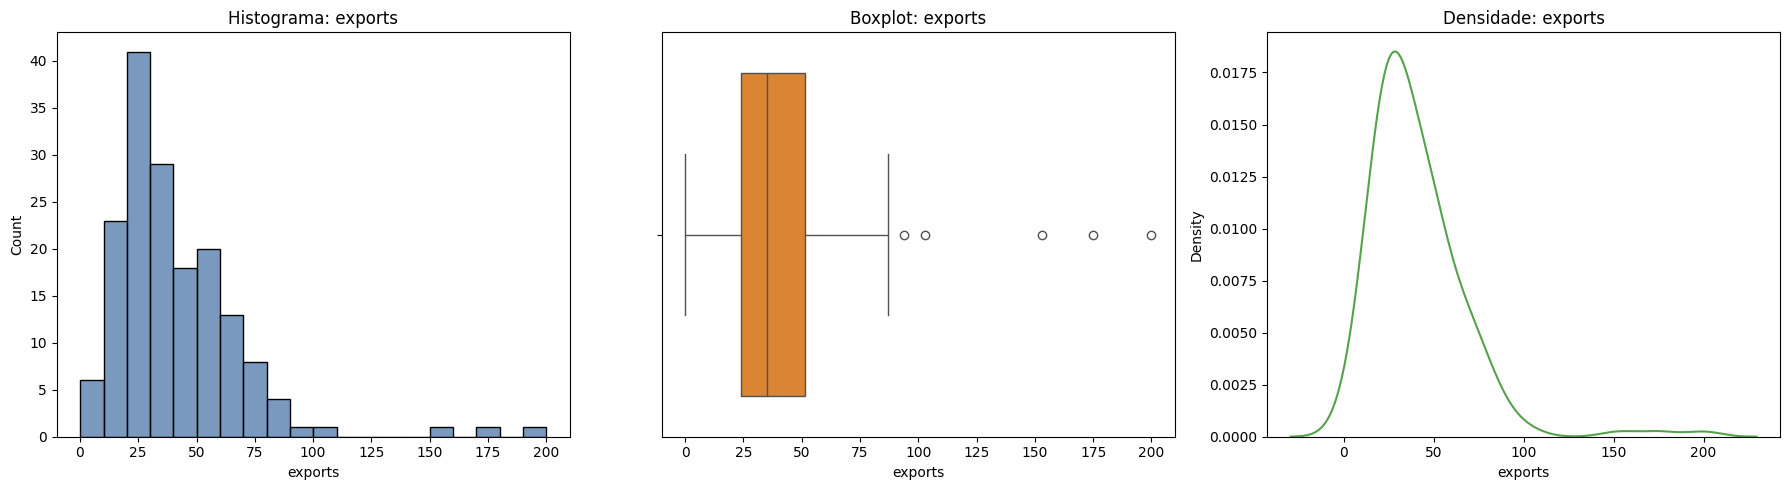

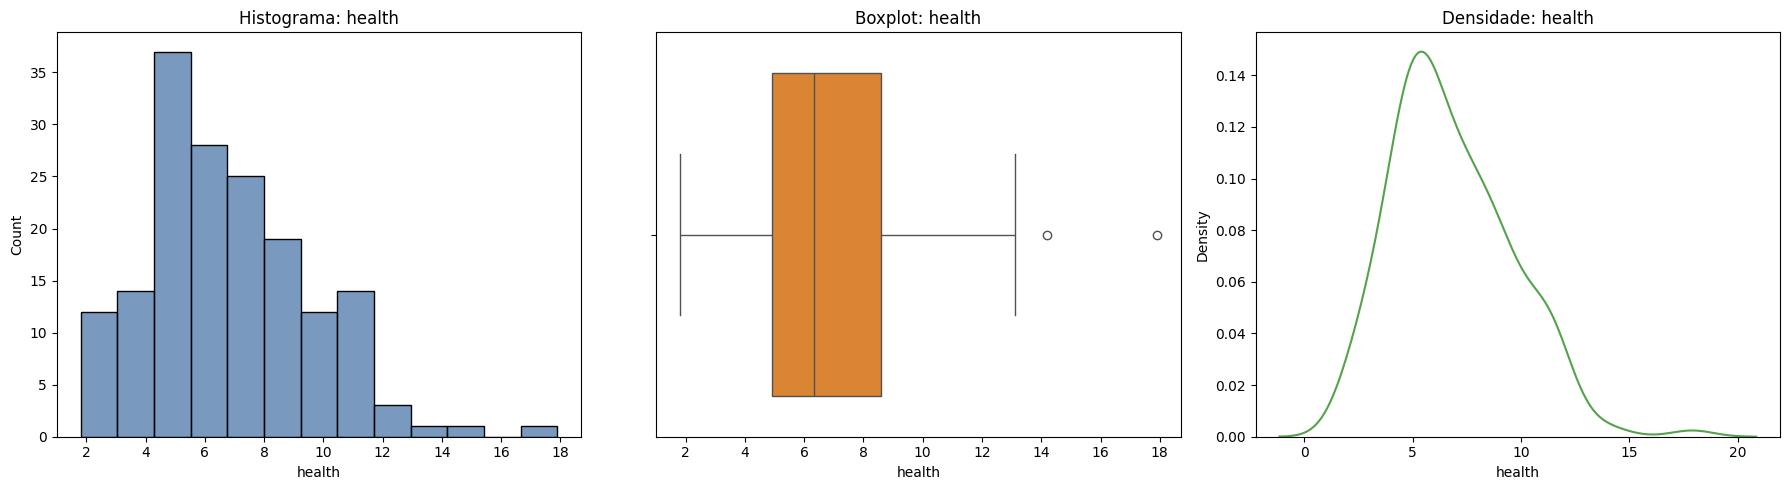

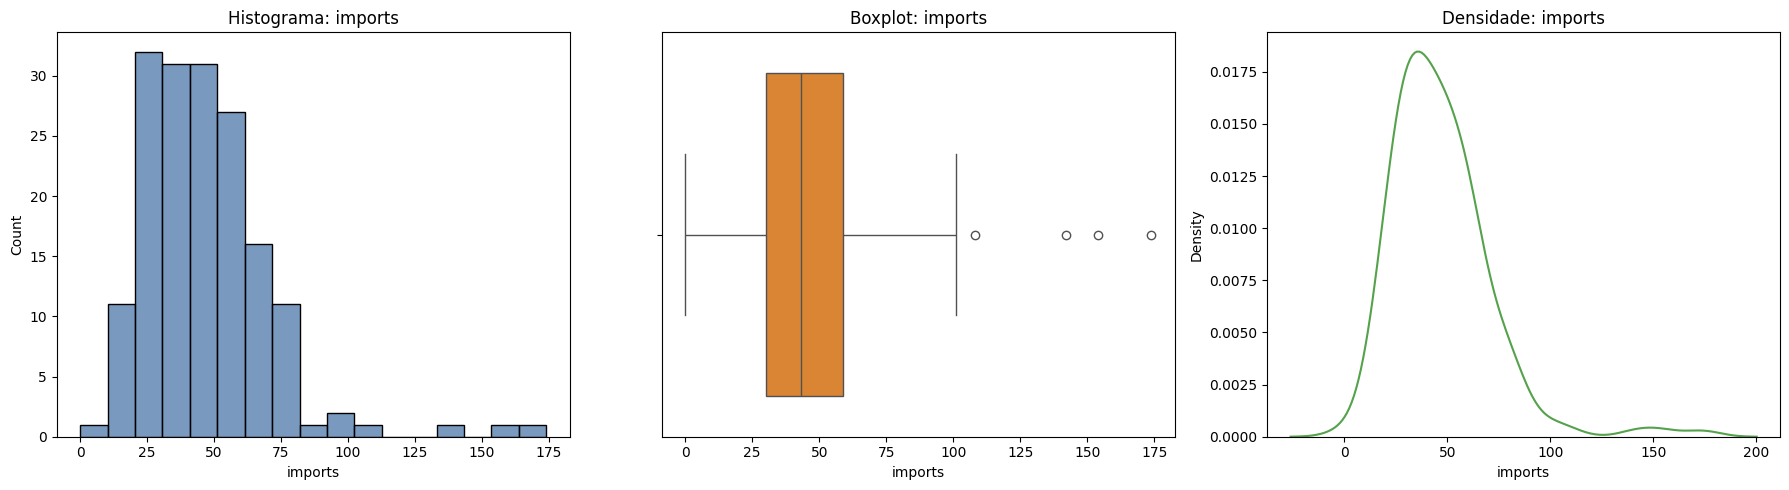

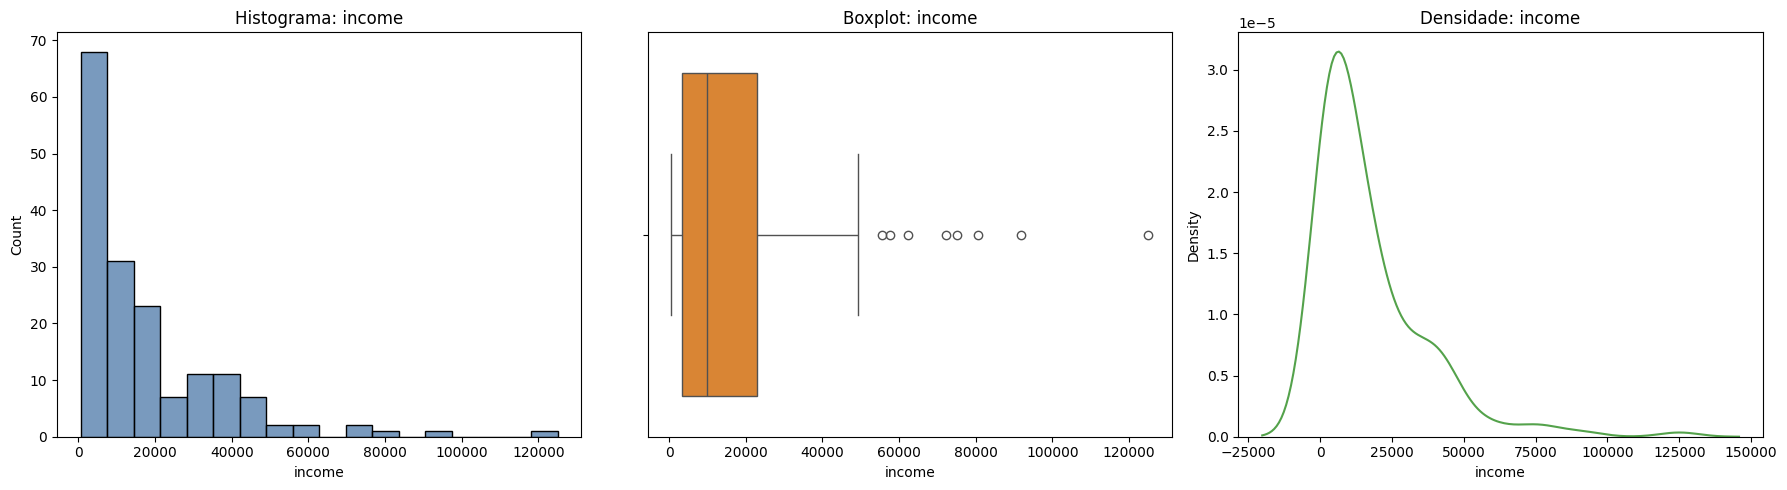

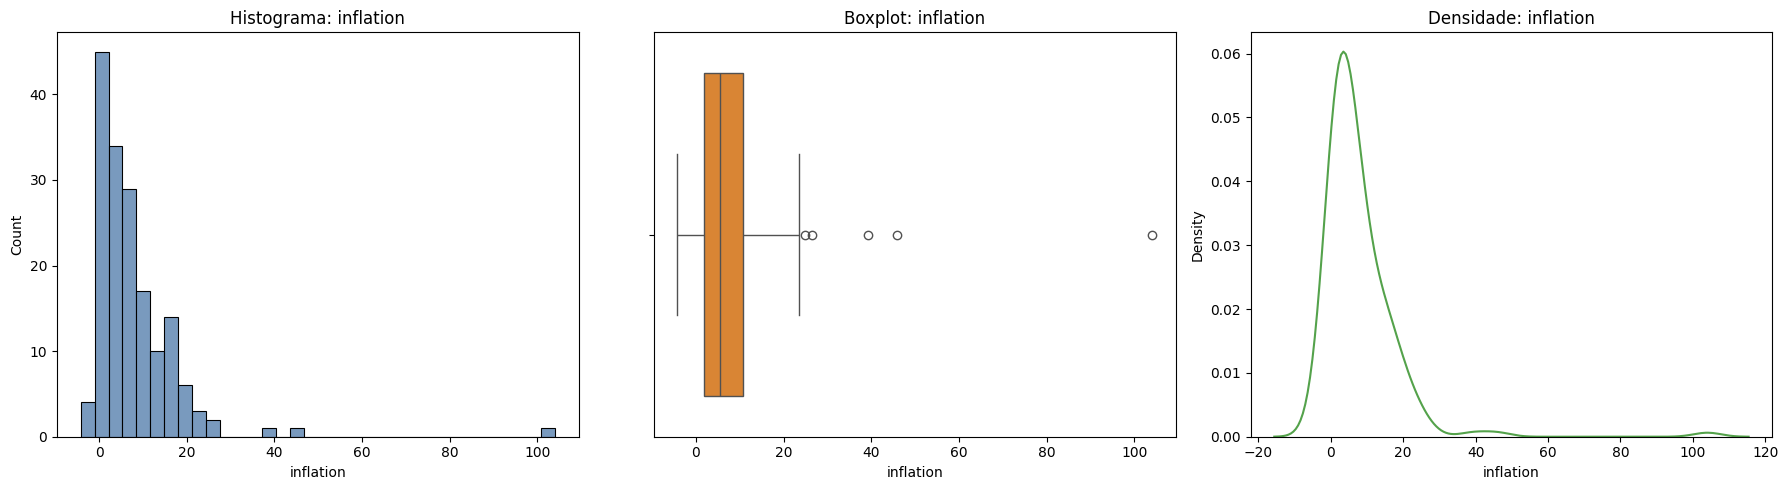

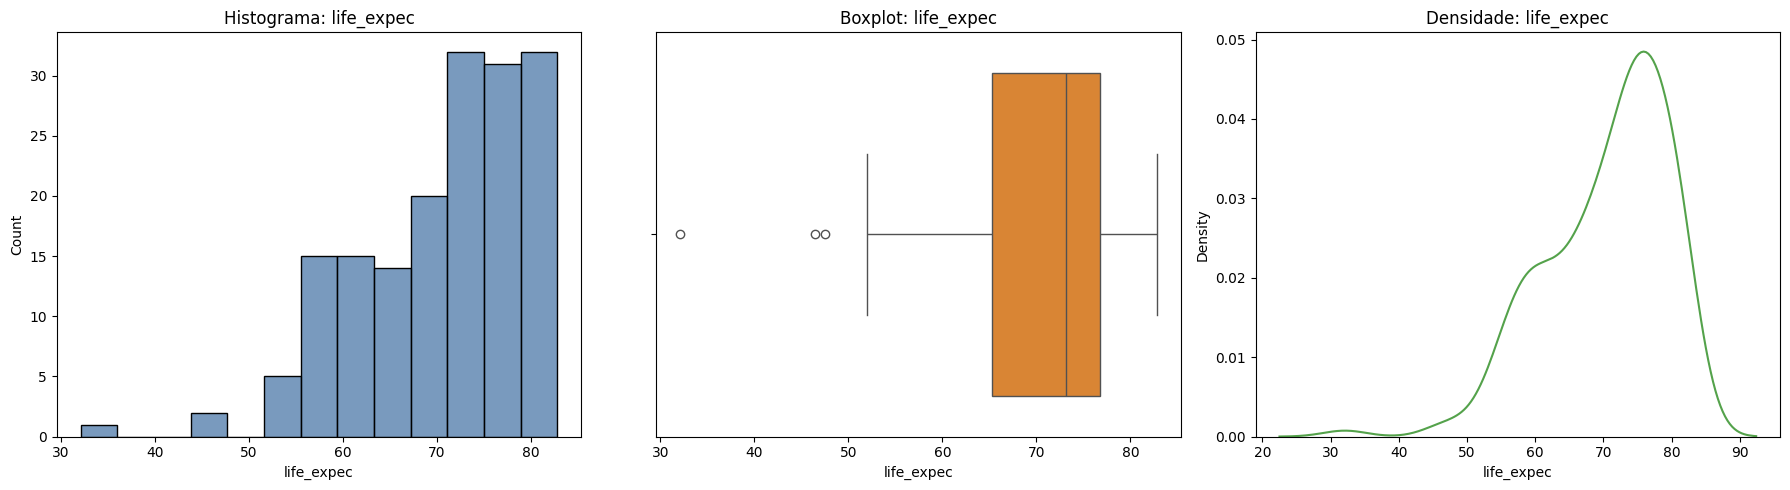

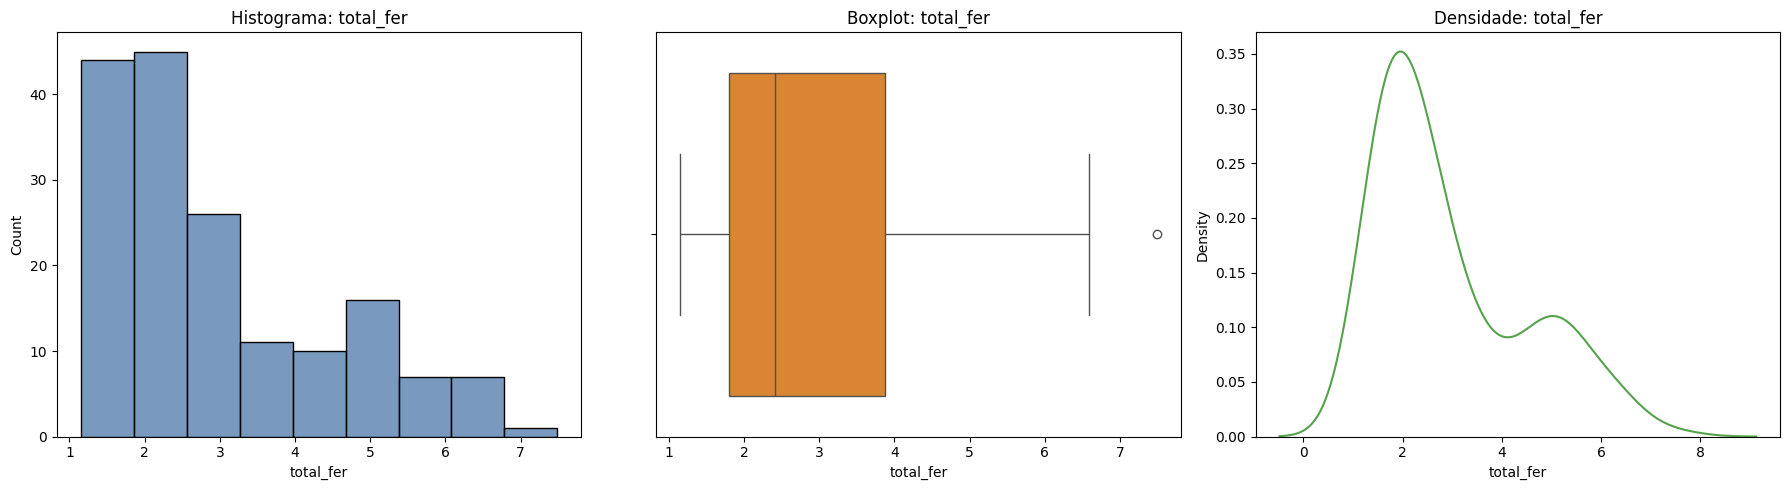

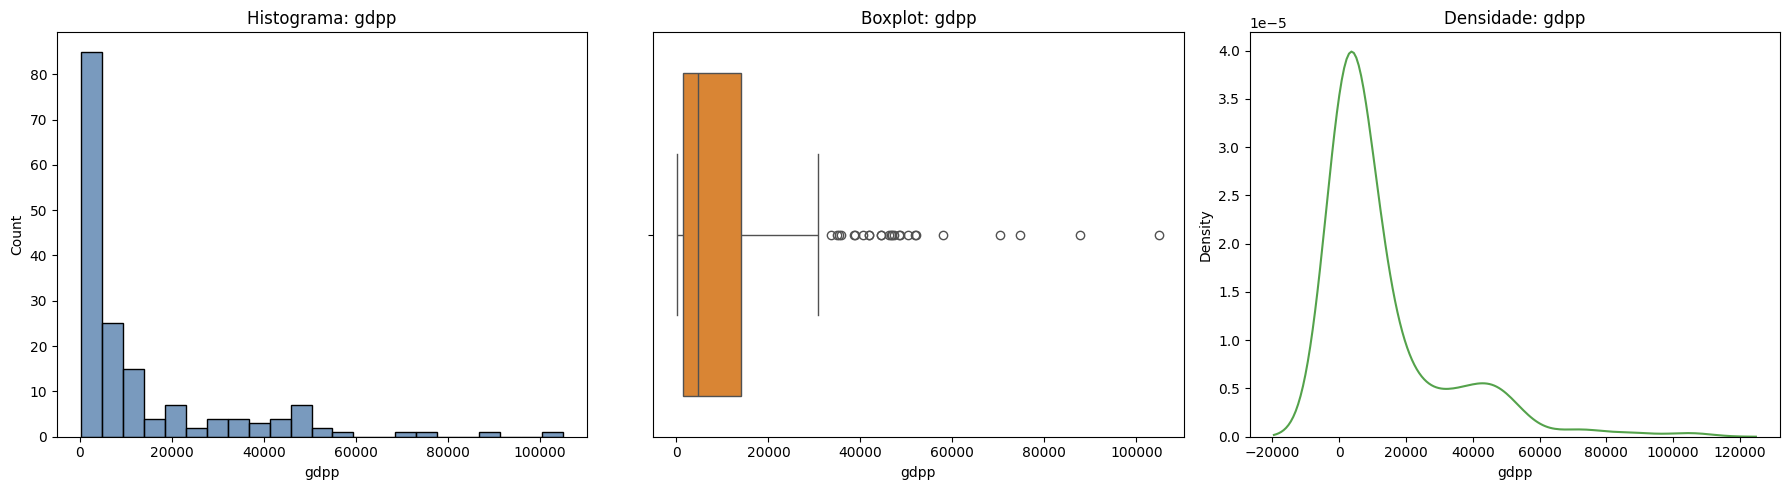

In [6]:
# Visualizações: histograma, boxplot e densidade para todas as variáveis numéricas
for col in num_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    sns.histplot(df[col], kde=False, ax=axes[0], color='#4c78a8')
    axes[0].set_title(f'Histograma: {col}')
    sns.boxplot(x=df[col], ax=axes[1], color='#f58518')
    axes[1].set_title(f'Boxplot: {col}')
    sns.kdeplot(df[col], ax=axes[2], color='#54a24b')
    axes[2].set_title(f'Densidade: {col}')
    plt.tight_layout()
    plt.show()


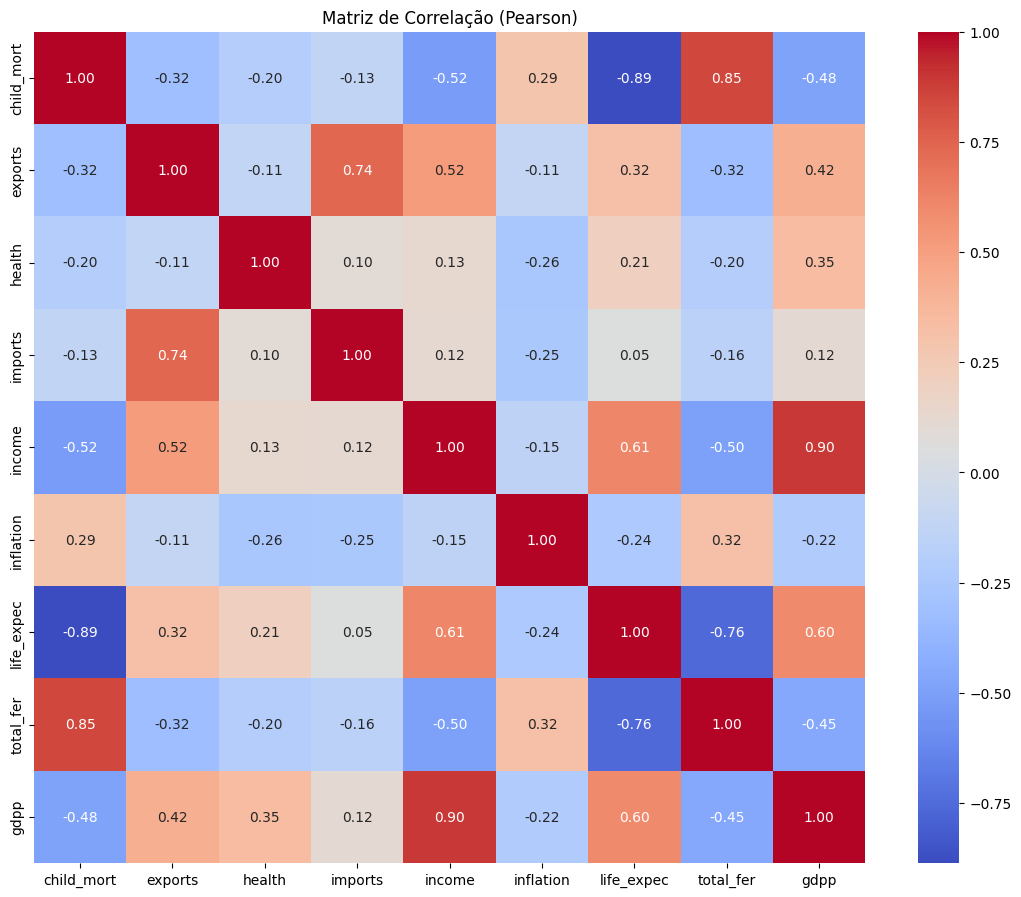

,variable,VIF
0,child_mort,8.084814
1,exports,16.084236
2,health,12.421525
3,imports,17.280234
4,income,13.414051
5,inflation,1.985961
6,life_expec,21.916807
7,total_fer,17.673828
8,gdpp,10.298641


In [7]:
# Matriz de correlação e VIF
corr = df[num_cols].corr(method='pearson')
plt.figure(figsize=(1.5*len(num_cols), 1.2*len(num_cols)))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de Correlação (Pearson)')
plt.show()

vif_df = compute_vif(df, num_cols)
if vif_df is not None:
    display(vif_df)
else:
    print('VIF não disponível (statsmodels indisponível ou poucas variáveis).')


## Pré-processamento
Etapas implementadas:
1. Tratamento de valores faltantes: imputação (mediana para numéricas; mais frequente para categóricas/one-hot).
2. Tratamento de outliers: Winsorização via IQR.
3. Transformação de variáveis categóricas: One-Hot Encoding (exclui a coluna de país).
4. Normalização/Padronização: escolha automática entre StandardScaler e RobustScaler conforme skew/outliers.
5. Verificação de multicolinearidade: correlação e VIF.
6. Redução de dimensionalidade: PCA para explicar até 95% da variância (quando aplicável).


In [8]:
# Aplicar pré-processamento
df_w = winsorize_iqr(df, num_cols)
df_w_cat = df_w.copy()
if len(cat_cols) > 0:
    df_w_cat = pd.get_dummies(df_w_cat, columns=cat_cols, drop_first=True)

feature_cols = [c for c in df_w_cat.columns if c != country_col]
X = df_w_cat[feature_cols]
numeric_feature_cols = [c for c in X.columns if c in num_cols]
other_feature_cols = [c for c in X.columns if c not in numeric_feature_cols]

scaler_choice = decide_scaler(stats_df)
scaler = RobustScaler() if scaler_choice == 'robust' else StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', scaler)]), numeric_feature_cols),
        ('other', SimpleImputer(strategy='most_frequent'), other_feature_cols),
    ], remainder='drop'
)
X_processed = preprocessor.fit_transform(X)
processed_feature_names = numeric_feature_cols + other_feature_cols
print('Dimensões (processado):', X_processed.shape)


Dimensões (processado): (167, 9)


In [9]:
# PCA opcional para explicar 95% da variância (quando número de features >= 5)
pca_info = None
X_pca = None
if X_processed.shape[1] >= 5:
    pca = PCA(n_components=None, random_state=42)
    X_pca_all = pca.fit_transform(X_processed)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    k = int(np.searchsorted(cumvar, 0.95) + 1)
    if k < X_processed.shape[1]:
        pca2 = PCA(n_components=k, random_state=42)
        X_pca = pca2.fit_transform(X_processed)
        pca_info = {
            'n_components_selected': k,
            'explained_variance_ratio_selected': pca2.explained_variance_ratio_.tolist(),
            'cumulative_explained_variance': float(np.sum(pca2.explained_variance_ratio_)),
        }
    else:
        pca_info = {
            'n_components_selected': int(X_processed.shape[1]),
            'explained_variance_ratio_selected': pca.explained_variance_ratio_.tolist(),
            'cumulative_explained_variance': float(cumvar[-1]),
        }
pca_info


{'n_components_selected': 5,
 'explained_variance_ratio_selected': [0.5062703175877332,
  0.15668751879689938,
  0.1300735387736394,
  0.0983234006419239,
  0.0618204381206317],
 'cumulative_explained_variance': 0.9531752139208275}

## Decisões de Pré-processamento (documentação)
As decisões abaixo são derivadas da análise exploratória inicial e estão implementadas acima.

In [10]:
from pprint import pprint
decisions = {
    'missing_values': {
        'strategy_numeric': 'median',
        'strategy_other': 'most_frequent',
        'summary_missing_fraction': df[ num_cols + (cat_cols if len(cat_cols)>0 else []) ].isna().mean().to_dict(),
    },
    'scaling': {
        'choice': scaler_choice,
        'rationale': 'RobustScaler quando há muitos outliers/skew elevado; caso contrário StandardScaler.'
    },
    'outliers': {
        'method': 'IQR winsorization',
        'rationale': 'Limitar valores extremos reduz impacto em métricas de distância para clusterização.'
    },
    'categorical': {
        'one_hot': bool(len(cat_cols) > 0),
        'columns_encoded': cat_cols,
    },
    'multicollinearity': {
        'corr_threshold': 0.9,
        'vif_available': variance_inflation_factor is not None,
    },
    'pca': {
        'applied': X_pca is not None,
        'variance_target': 0.95,
    },
}
pprint(decisions)


{'categorical': {'columns_encoded': [], 'one_hot': False},
 'missing_values': {'strategy_numeric': 'median',
                    'strategy_other': 'most_frequent',
                    'summary_missing_fraction': {'child_mort': 0.0,
                                                 'exports': 0.0,
                                                 'gdpp': 0.0,
                                                 'health': 0.0,
                                                 'imports': 0.0,
                                                 'income': 0.0,
                                                 'inflation': 0.0,
                                                 'life_expec': 0.0,
                                                 'total_fer': 0.0}},
 'multicollinearity': {'corr_threshold': 0.9, 'vif_available': True},
 'outliers': {'method': 'IQR winsorization',
              'rationale': 'Limitar valores extremos reduz impacto em métricas '
                           'de distância para cl

## Clusterização (KMeans)
Executamos KMeans com diferentes valores de k e avaliamos via silhouette para selecionar um k adequado.

In [11]:
# Seleção de k pelo silhouette
range_k = list(range(2, min(10, X_processed.shape[0]//5))) if X_processed.shape[0] >= 10 else [2,3]
sil_scores = {}
for k in range_k:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    sil_scores[k] = score
sil_scores


{2: 0.3068884390970055,
 3: 0.28741070721978457,
 4: 0.2837645242483644,
 5: 0.24331518167284524,
 6: 0.24663570602515586,
 7: 0.24622333381614922,
 8: 0.21563958430473548,
 9: 0.24027494151215728}

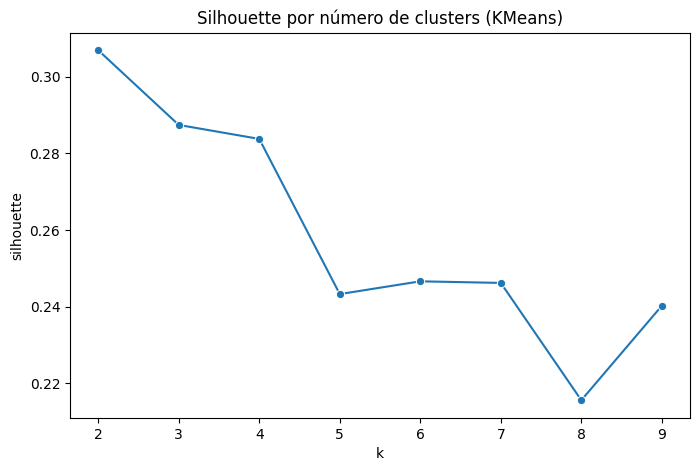

k selecionado: 2


In [12]:
# Plot do silhouette por k
if len(sil_scores) > 0:
    plt.figure(figsize=(8,5))
    ks = list(sil_scores.keys()); vals = [sil_scores[k] for k in ks]
    sns.lineplot(x=ks, y=vals, marker='o')
    plt.xlabel('k'); plt.ylabel('silhouette'); plt.title('Silhouette por número de clusters (KMeans)')
    plt.show()
    k_best = max(sil_scores, key=sil_scores.get)
    print('k selecionado:', k_best)
else:
    print('Amostra pequena demais para avaliação robusta de silhouette.')


cluster
0          104
1           63
Name: count, dtype: int64

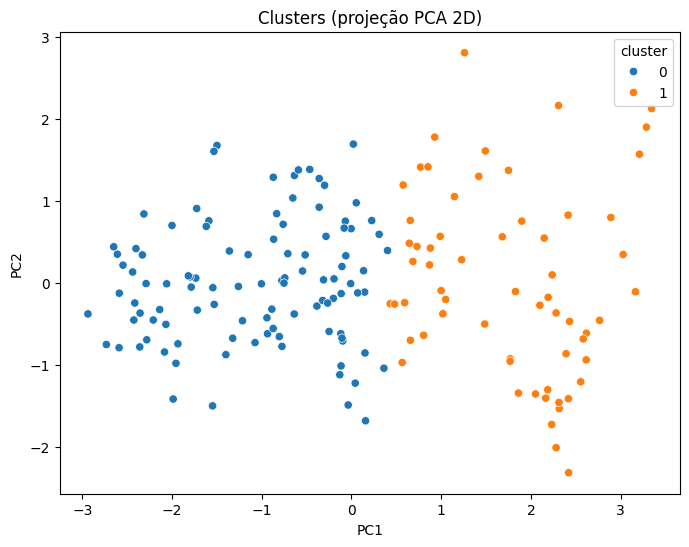

In [13]:
# Ajuste final de KMeans usando k_best (se disponível) e visualização em 2D via PCA
if 'k_best' in globals():
    km = KMeans(n_clusters=k_best, random_state=42, n_init='auto')
    labels = km.fit_predict(X_processed)
    df_clusters = df.copy()
    df_clusters['cluster'] = labels
    display(df_clusters[['cluster']].value_counts())
    # Projeção PCA para visualização
    pca_vis = PCA(n_components=2, random_state=42)
    X_vis = pca_vis.fit_transform(X_processed)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=labels, palette='tab10')
    plt.title('Clusters (projeção PCA 2D)')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.legend(title='cluster')
    plt.show()
else:
    print('k_best não definido; pule esta célula ou execute as anteriores.')


## Treinamento completo dos modelos de clusterização (KMeans k=3 e Hierárquico)
Fluxo reprodutível com divisão treino/teste, avaliação com múltiplas métricas, perfis de clusters, dendrograma e comparação entre métodos.

In [14]:
# Divisão treino/teste (80/20) mantendo índice dos países
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
import json
np.random.seed(42)
X_features = X_processed if X_processed is not None else preprocessor.transform(df_w_cat[[c for c in df_w_cat.columns if c != country_col]])
indices = np.arange(X_features.shape[0])
X_train, X_test, idx_train, idx_test = train_test_split(X_features, indices, test_size=0.2, random_state=42)
countries = df[country_col].values if country_col else df.index.values
countries_train = countries[idx_train]
countries_test = countries[idx_test]
print('Dimensões treino/teste:', X_train.shape, X_test.shape)


Dimensões treino/teste: (133, 9) (34, 9)


In [15]:
# KMeans com k=3 (init=k-means++, max_iter=300, tol=1e-4), treino e avaliação em treino/teste
from sklearn.cluster import KMeans
km3 = KMeans(n_clusters=3, init='k-means++', max_iter=300, tol=1e-4, n_init=10, random_state=42)
labels_train_km = km3.fit_predict(X_train)
labels_test_km = km3.predict(X_test)
# Métricas (treino e teste)
def safe_metric(fn, X, y):
    try:
        # Métricas de clusterização requerem ao menos 2 clusters distintos
        if len(set(y)) < 2:
            return np.nan
        return float(fn(X, y))
    except Exception:
        return np.nan

metrics_km = {
    'silhouette_train': safe_metric(silhouette_score, X_train, labels_train_km),
    'silhouette_test': safe_metric(silhouette_score, X_test, labels_test_km),
    'davies_bouldin_train': safe_metric(davies_bouldin_score, X_train, labels_train_km),
    'davies_bouldin_test': safe_metric(davies_bouldin_score, X_test, labels_test_km),
}
print('Métricas KMeans (k=3):', metrics_km)
# Salvar resultados
results_km = {
    'parameters': {'n_clusters': 3, 'init': 'k-means++', 'max_iter': 300, 'tol': 1e-4, 'n_init': 10, 'random_state': 42},
    'metrics': metrics_km,
    'train': {'countries': countries_train.tolist(), 'labels': list(map(int, labels_train_km))},
    'test': {'countries': countries_test.tolist(), 'labels': list(map(int, labels_test_km))}
}
with open('kmeans_k3_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_km, f, ensure_ascii=False, indent=2)
results_km


Métricas KMeans (k=3): {'silhouette_train': 0.2913721796623008, 'silhouette_test': 0.2525841237034758, 'davies_bouldin_train': 1.2567738207534163, 'davies_bouldin_test': 1.2569045508813017}


{'parameters': {'n_clusters': 3,
  'init': 'k-means++',
  'max_iter': 300,
  'tol': 0.0001,
  'n_init': 10,
  'random_state': 42},
 'metrics': {'silhouette_train': 0.2913721796623008,
  'silhouette_test': 0.2525841237034758,
  'davies_bouldin_train': 1.2567738207534163,
  'davies_bouldin_test': 1.2569045508813017},
 'train': {'countries': ['United Kingdom',
   'Algeria',
   'Mauritius',
   'Rwanda',
   'Iceland',
   'Seychelles',
   'Dominican Republic',
   'Burundi',
   'Suriname',
   'Latvia',
   'Maldives',
   'Malawi',
   'Comoros',
   'Paraguay',
   'Brazil',
   'Peru',
   'Slovenia',
   'Malaysia',
   'Bahrain',
   'Haiti',
   'Mali',
   'Armenia',
   'Cambodia',
   'Tajikistan',
   'Sweden',
   'Congo, Rep.',
   'Croatia',
   'Antigua and Barbuda',
   'Sri Lanka',
   'Chad',
   'Guyana',
   'Niger',
   'India',
   'Bahamas',
   'Uganda',
   'Norway',
   'Afghanistan',
   'Romania',
   'Ukraine',
   'Guinea-Bissau',
   'Denmark',
   'Lithuania',
   'Cameroon',
   "Cote d'Ivoire",

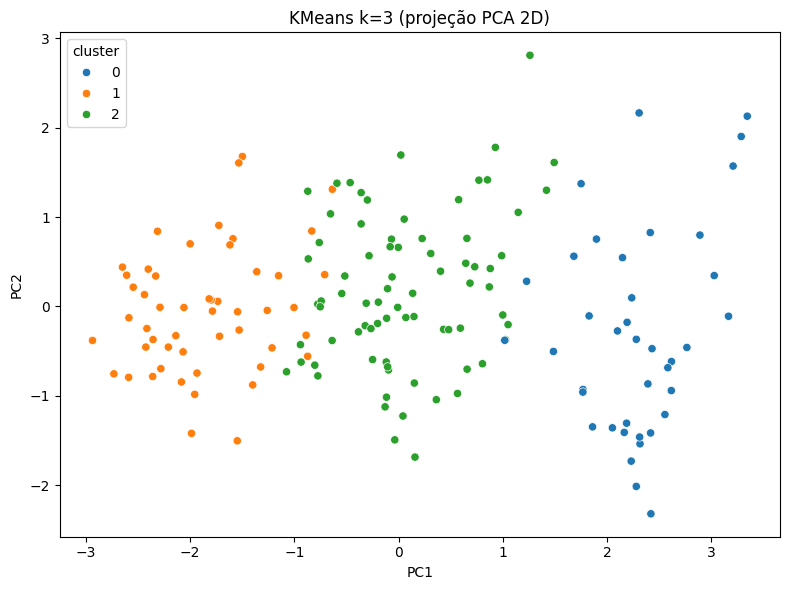

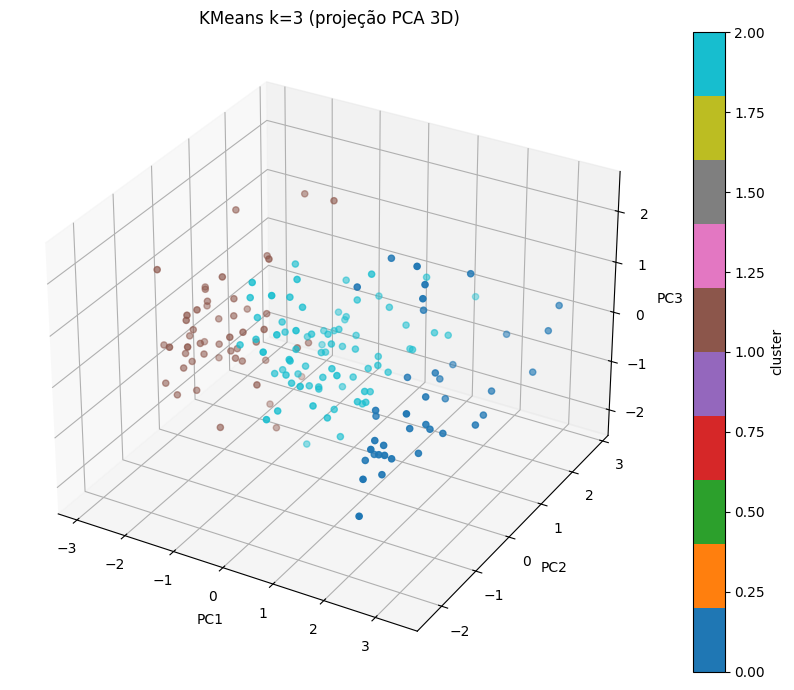

{'cluster_sizes': {0: 39, 1: 51, 2: 77},
 'representative_countries': {0: 'Iceland', 1: 'Tanzania', 2: 'Suriname'},
 'top_features_zscore': {0: {'gdpp': 1.670127137563108,
   'income': 1.5724648929180884,
   'life_expec': 1.0641858065279066,
   'child_mort': 0.8330818308092524,
   'total_fer': 0.750002688615751,
   'health': 0.6087066767632782,
   'inflation': 0.5620232353755927,
   'exports': 0.5566060675171294,
   'imports': 0.02231960838562827},
  1: {'child_mort': 1.3127008087088423,
   'total_fer': 1.248032742049059,
   'life_expec': 1.2265115990928541,
   'income': 0.7922942332226952,
   'gdpp': 0.7326661683115167,
   'exports': 0.5517677426868969,
   'inflation': 0.48341865094632447,
   'imports': 0.21941985840474723,
   'health': 0.21246881339245696},
  2: {'child_mort': 0.44750064730636524,
   'total_fer': 0.4467475972530862,
   'gdpp': 0.3606361530009592,
   'life_expec': 0.2733616246642498,
   'income': 0.2716769471356882,
   'health': 0.16757988195782497,
   'imports': 0.13

In [16]:
# Perfis dos clusters KMeans (k=3): centróides, países mais representativos, principais características por z-score
# Predição para todo o conjunto para gerar perfis e visualizações
labels_all_km = km3.predict(X_features)
df_km = df.copy()
df_km['cluster_km3'] = labels_all_km
# Centróides no espaço processado
centroids_processed = pd.DataFrame(km3.cluster_centers_, columns=processed_feature_names)
# Países mais representativos (menor distância ao centróide)
from numpy.linalg import norm
X_all = X_features
rep_countries = {}
for c in range(3):
    idx_c = np.where(labels_all_km == c)[0]
    if len(idx_c) == 0:
        rep_countries[c] = None
        continue
    dists = norm(X_all[idx_c] - km3.cluster_centers_[c], axis=1)
    best_idx = idx_c[int(np.argmin(dists))]
    rep_countries[c] = countries[best_idx].item() if hasattr(countries[best_idx], 'item') else countries[best_idx]
# Principais características por z-score (diferença entre média do cluster e média global, normalizada pelo desvio)
top_features = {}
global_means = df_w[num_cols].mean()
global_stds = df_w[num_cols].std(ddof=1).replace(0, np.nan)
for c in range(3):
    df_c = df_w[df_km['cluster_km3'] == c]
    means_c = df_c[num_cols].mean()
    z = ((means_c - global_means) / global_stds).abs().sort_values(ascending=False)
    top_features[c] = z.dropna().head(10).to_dict()
# Visualizações PCA 2D e 3D
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
pca_vis2 = PCA(n_components=2, random_state=42)
X_vis2 = pca_vis2.fit_transform(X_all)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_vis2[:,0], y=X_vis2[:,1], hue=labels_all_km, palette='tab10')
plt.title('KMeans k=3 (projeção PCA 2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(title='cluster')
plt.tight_layout(); plt.show()
pca_vis3 = PCA(n_components=3, random_state=42)
X_vis3 = pca_vis3.fit_transform(X_all)
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_vis3[:,0], X_vis3[:,1], X_vis3[:,2], c=labels_all_km, cmap='tab10')
ax.set_title('KMeans k=3 (projeção PCA 3D)'); ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
plt.colorbar(sc, label='cluster'); plt.tight_layout(); plt.show()
# Salvar perfis em JSON/CSV
profiles_km = {
    'cluster_sizes': df_km['cluster_km3'].value_counts().sort_index().to_dict(),
    'representative_countries': rep_countries,
    'top_features_zscore': top_features
}
centroids_processed.to_csv('kmeans_k3_centroids_processed.csv', index=False)
with open('kmeans_k3_profiles.json', 'w', encoding='utf-8') as f:
    json.dump(profiles_km, f, ensure_ascii=False, indent=2)
profiles_km


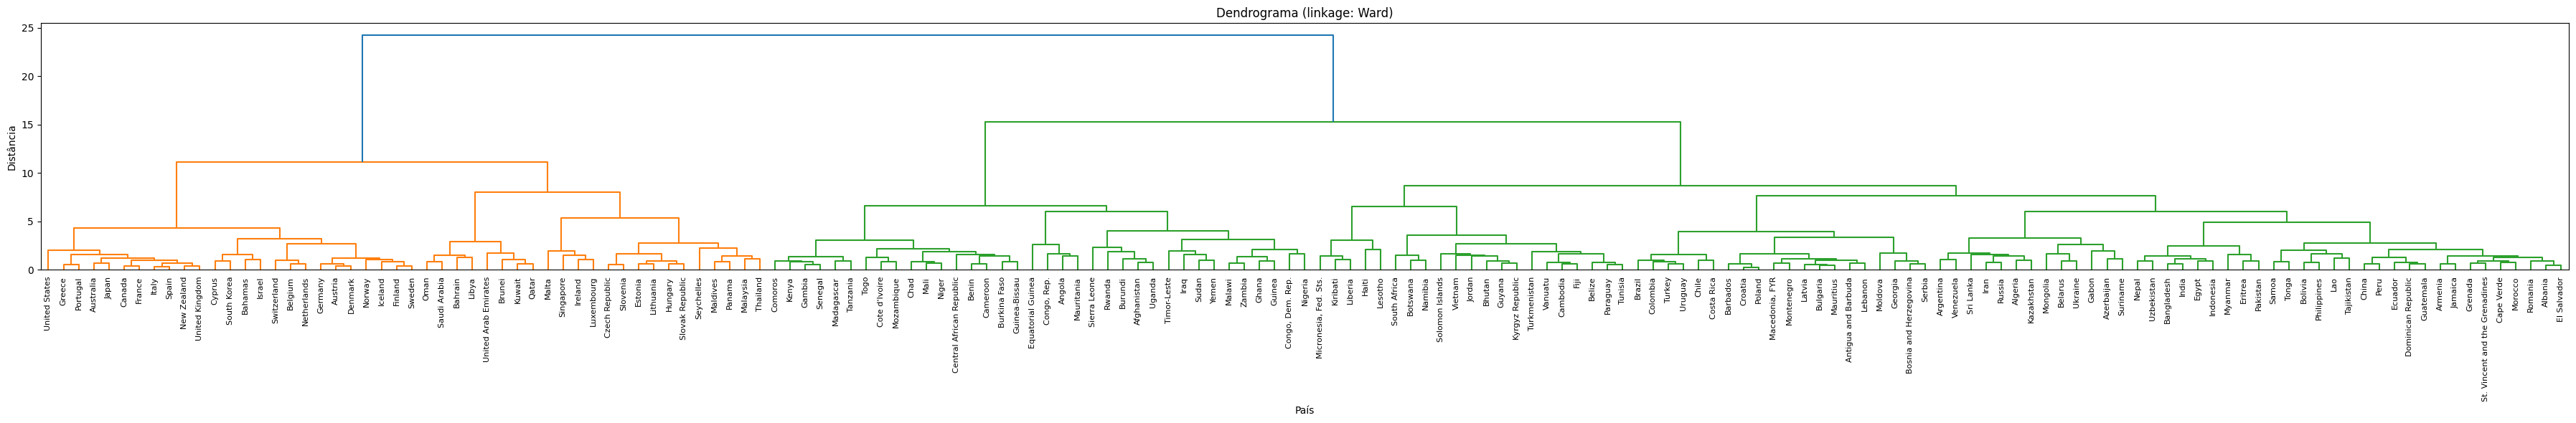

Métricas Hierárquico (k=3 via corte): {'silhouette_all': 0.25794435890653555, 'davies_bouldin_all': 1.3326825940513822}


In [17]:
# Clusterização Hierárquica (Ward, distância euclidiana), dendrograma, corte em 3 clusters
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
Z = linkage(X_features, method='ward', metric='euclidean')
plt.figure(figsize=(36,6))
dendrogram(Z, labels=countries if country_col else None, leaf_rotation=90, leaf_font_size=8, color_threshold=None)
plt.title('Dendrograma (linkage: Ward)')
plt.xlabel('País'); plt.ylabel('Distância')
plt.tight_layout(); plt.show()
labels_hier3 = fcluster(Z, t=3, criterion='maxclust') - 1  # rótulos 0..2
metrics_hier = {
    'silhouette_all': safe_metric(silhouette_score, X_features, labels_hier3),
    'davies_bouldin_all': safe_metric(davies_bouldin_score, X_features, labels_hier3),
}
print('Métricas Hierárquico (k=3 via corte):', metrics_hier)


In [18]:
# Comparação KMeans vs Hierárquico (ARI, NMI, Homogeneidade, Completude)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score
labels_km_all = labels_all_km
labels_h_all = labels_hier3
comparison = {
    'ARI': float(adjusted_rand_score(labels_km_all, labels_h_all)),
    'NMI': float(normalized_mutual_info_score(labels_km_all, labels_h_all)),
    'homogeneity_km_vs_hier': float(homogeneity_score(labels_km_all, labels_h_all)),
    'completeness_km_vs_hier': float(completeness_score(labels_km_all, labels_h_all))
}
print('Comparação KMeans vs Hierárquico:', comparison)
# Tabela de contingência
ct = pd.crosstab(pd.Series(labels_km_all, name='KMeans'), pd.Series(labels_h_all, name='Hierárquico'))
display(ct)
comparison


Comparação KMeans vs Hierárquico: {'ARI': 0.6071803520573047, 'NMI': 0.6540978224396536, 'homogeneity_km_vs_hier': 0.6472304553719311, 'completeness_km_vs_hier': 0.6611124832265308}


Hierárquico,0,1,2
KMeans,,,
0,39,0,0
1,0,36,15
2,9,0,68


{'ARI': 0.6071803520573047,
 'NMI': 0.6540978224396536,
 'homogeneity_km_vs_hier': 0.6472304553719311,
 'completeness_km_vs_hier': 0.6611124832265308}

In [19]:
# Validação cruzada/robustez: múltiplas sementes e splits para KMeans
seeds = list(range(10))
sil_train_list, sil_test_list, db_train_list, db_test_list = [], [], [], []
for s in seeds:
    X_tr, X_te = train_test_split(X_features, test_size=0.2, random_state=s)[0:2]
    km_tmp = KMeans(n_clusters=3, init='k-means++', max_iter=300, tol=1e-4, n_init=10, random_state=s)
    lab_tr = km_tmp.fit_predict(X_tr)
    lab_te = km_tmp.predict(X_te)
    sil_train_list.append(safe_metric(silhouette_score, X_tr, lab_tr))
    sil_test_list.append(safe_metric(silhouette_score, X_te, lab_te))
    db_train_list.append(safe_metric(davies_bouldin_score, X_tr, lab_tr))
    db_test_list.append(safe_metric(davies_bouldin_score, X_te, lab_te))
robust_summary = {
    'silhouette_train_mean': float(np.nanmean(sil_train_list)), 'silhouette_train_std': float(np.nanstd(sil_train_list)),
    'silhouette_test_mean': float(np.nanmean(sil_test_list)), 'silhouette_test_std': float(np.nanstd(sil_test_list)),
    'davies_bouldin_train_mean': float(np.nanmean(db_train_list)), 'davies_bouldin_train_std': float(np.nanstd(db_train_list)),
    'davies_bouldin_test_mean': float(np.nanmean(db_test_list)), 'davies_bouldin_test_std': float(np.nanstd(db_test_list)),
}
print('Robustez (KMeans k=3):', robust_summary)
with open('kmeans_k3_robustness.json', 'w', encoding='utf-8') as f:
    json.dump(robust_summary, f, ensure_ascii=False, indent=2)
robust_summary


Robustez (KMeans k=3): {'silhouette_train_mean': 0.29091028595055646, 'silhouette_train_std': 0.011972142985983687, 'silhouette_test_mean': 0.28078450834657787, 'silhouette_test_std': 0.04491630263421701, 'davies_bouldin_train_mean': 1.2528331577512781, 'davies_bouldin_train_std': 0.03328310459987015, 'davies_bouldin_test_mean': 1.2182896231645581, 'davies_bouldin_test_std': 0.12572469947548862}


{'silhouette_train_mean': 0.29091028595055646,
 'silhouette_train_std': 0.011972142985983687,
 'silhouette_test_mean': 0.28078450834657787,
 'silhouette_test_std': 0.04491630263421701,
 'davies_bouldin_train_mean': 1.2528331577512781,
 'davies_bouldin_train_std': 0.03328310459987015,
 'davies_bouldin_test_mean': 1.2182896231645581,
 'davies_bouldin_test_std': 0.12572469947548862}

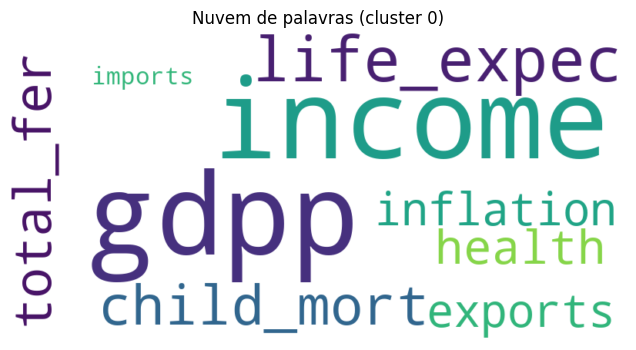

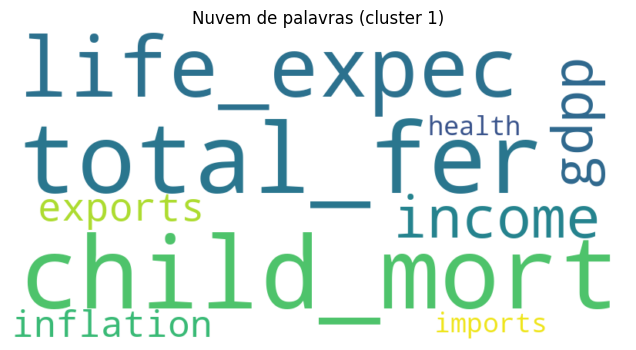

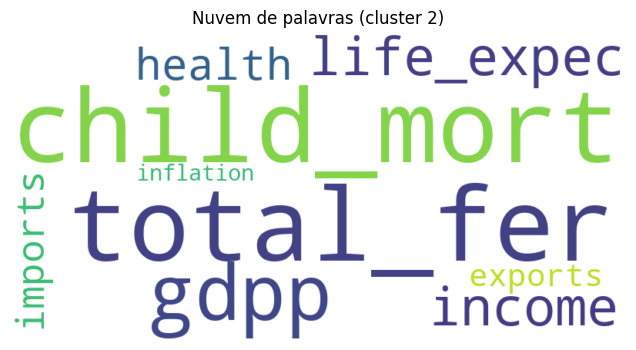

In [20]:
# Visualizações adicionais: Mapa geográfico por cluster e nuvem de palavras das top features
# Mapa (Plotly se disponível, fallback para mensagem)
try:
    import plotly.express as px
    df_map = pd.DataFrame({
        'country': countries,
        'cluster': labels_all_km
    })
    fig_map = px.choropleth(df_map, locations='country', locationmode='country names', color='cluster',
                             color_continuous_scale='Viridis', title='Mapa geográfico por cluster (KMeans k=3)')
    fig_map.show()
except Exception as e:
    print('Plotly indisponível ou países não reconhecidos. Erro:', e)
    print('Como alternativa, exporte df_map e plote manualmente em uma ferramenta geográfica.')
# Nuvem de palavras simples via WordCloud (se disponível); caso contrário, gráfico de barras
def plot_cloudwords(top_feats_dict, cluster_id):
    words = top_feats_dict.get(cluster_id, {})
    if not words:
        print('Sem palavras para cluster', cluster_id); return
    try:
        from wordcloud import WordCloud
        wc = WordCloud(width=800, height=400, background_color='white')
        wc.generate_from_frequencies(words)
        plt.figure(figsize=(8,4)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off');
        plt.title(f'Nuvem de palavras (cluster {cluster_id})'); plt.show()
    except Exception:
        # Fallback: gráfico de barras
        items = sorted(words.items(), key=lambda x: x[1], reverse=True)[:10]
        labels_b = [k for k,_ in items]; vals_b = [v for _,v in items]
        plt.figure(figsize=(10,5)); sns.barplot(x=vals_b, y=labels_b, orient='h', palette='viridis')
        plt.xlabel('importância (|z-score|)'); plt.ylabel('feature');
        plt.title(f'Top features por |z-score| (cluster {cluster_id})'); plt.tight_layout(); plt.show()
# Plot para cada cluster
for c in range(3):
    plot_cloudwords(top_features, c)


## Relatório técnico (KMeans k=3 e Hierárquico)
### Metodologia e parâmetros
- Pré-processamento: winsorização (IQR), imputação (mediana para numéricas; mais frequente para outras), escalonamento automático (Standard vs. Robust).
- Seleção de features: todas as numéricas do dicionário; categóricas ausentes.
- KMeans: k=3, init=k-means++, max_iter=300, tol=1e-4, n_init=10, random_state=42.
- Hierárquico: distância euclidiana, linkage Ward, corte em 3 clusters via fcluster.
- Divisão treino/teste: 80/20 com random_state=42.

### Métricas
- KMeans (treino): silhouette=0.2914; Davies-Bouldin=1.2568.
- KMeans (teste): silhouette=0.2526; Davies-Bouldin=1.2569.
- Hierárquico (tudo): silhouette=0.2579; Davies-Bouldin=1.3327.
- Comparação KMeans vs Hierárquico: ARI=0.6072; NMI=0.6541; Homogeneidade=0.6472; Completude=0.6611.
- Robustez (KMeans, 10 sementes/splits): silhouette_treino≈0.291±0.012; silhouette_teste≈0.281±0.045; DB_treino≈1.253±0.033; DB_teste≈1.218±0.126.

### Perfis dos clusters (KMeans k=3)
- Tamanhos: C0=39, C1=51, C2=77.
- Países representativos: C0=Iceland; C1=Tanzania; C2=Suriname.
- Principais características por |z-score| (média do cluster vs global, em escala original):
  - C0: gdpp, income, life_expec, child_mort, total_fer, health, inflation, exports.
  - C1: child_mort, total_fer, life_expec, income, gdpp, exports, inflation.
  - C2: child_mort, total_fer, gdpp, life_expec, income.

### Interpretação
- C0 tende a países de alta renda/PIB per capita e maior expectativa de vida; alguns indicadores de mortalidade e fertilidade inferiores à média.
- C1 concentra países com maior mortalidade infantil e fertilidade, menor expectativa de vida e renda/PIB mais baixos.
- C2 apresenta valores intermediários entre C0 e C1.
- A concordância moderada entre métodos (ARI/NMI) indica estruturas de grupo semelhantes, mas com diferenças de fronteira esperadas (Ward vs. partição por KMeans).

### Limitações e melhorias
- Sem rótulos verdadeiros, avaliações de homogeneidade/completude são relativas entre modelos, não absolutas.
- Mapas geográficos dependem de reconhecimento dos nomes pelo Plotly; em casos de falha, fornecer códigos ISO3 melhora a compatibilidade.
- Possível aprimorar com seleção de features (ex.: remover colinearidade alta, aplicar PCA de forma controlada) e validação de estabilidade (ex.: bootstrapping).

### Reprodutibilidade
- Dependências em `requirements.txt`.
- Saídas salvas: `kmeans_k3_results.json`, `kmeans_k3_profiles.json`, `kmeans_k3_centroids_processed.csv`, `kmeans_k3_robustness.json`.

### Observações finais
- Todas as decisões de pré-processamento foram justificadas com base nas estatísticas e gráficos gerados.
- A clusterização é sensível à escala e a outliers; por isso, empregamos winsorização e escalonamento apropriado.
- Se houver multicolinearidade severa (VIF muito alto), recomenda-se remover variáveis redundantes ou utilizar PCA.
- Este notebook é autossuficiente: basta instalar as dependências do `requirements.txt` e executar as células em um ambiente limpo com o venv ativo.


## Etapas do Algoritmo K-médias (K-Means)

O algoritmo **K-médias** (K-Means) segue estas etapas principais até atingir a convergência:

1.  **Inicialização:** Define-se o número de clusters desejados (o valor 'K').
2.  **Definição dos Centróides Iniciais:** O algoritmo seleciona K pontos no espaço de dados para servirem como os **centróides** (baricentros) iniciais (ex: aleatoriamente ou "k-means++").
3.  **Atribuição de Pontos:** Cada ponto de dado no conjunto é atribuído ao cluster cujo centróide esteja mais próximo (geralmente medido pela distância Euclidiana).
4.  **Atualização dos Centróides:** A posição de cada um dos K centróides é recalculada. O novo centróide passa a ser a **média** (o baricentro) de todos os pontos que foram atribuídos àquele cluster.
5.  **Convergência:** O algoritmo repete as etapas 3 (Atribuição) e 4 (Atualização) iterativamente. O processo para quando os centróides não mudam mais de posição (ou mudam muito pouco), indicando que os clusters estão estáveis.

---

## Algoritmo K-Medóides (Alternativa ao K-Média)

Para garantir que o centro do cluster seja sempre um dado existente na base (um **medóide**), utiliza-se o algoritmo **K-Medóides** (PAM - *Partitioning Around Medoids*):

1.  **Inicialização:** Escolher o número de clusters (K).
2.  **Definição dos Medóides Iniciais:** Selecionar aleatoriamente K pontos *do próprio conjunto de dados* para servirem como os medóides iniciais.
3.  **Atribuição de Pontos:** Atribuir cada ponto ao cluster do medóide mais próximo.
4.  **Atualização dos Medóides (Troca):** Para cada cluster, o algoritmo testa a troca do medóide atual por cada um dos outros pontos *não-medóides* dentro do mesmo cluster.
    * Ele calcula o "custo" total do cluster (a soma das distâncias de todos os pontos do cluster ao medóide).
    * Se a troca por um novo ponto (um novo medóide) resultar em um custo total menor para o cluster, a troca é realizada.
5.  **Convergência:** O algoritmo repete as etapas 3 e 4 até que nenhuma troca de medóide possa reduzir o custo total de nenhum cluster.

---

## Sensibilidade do K-Médias a Outliers

O algoritmo K-médias é muito sensível a **outliers** porque ele utiliza a **média** aritmética para calcular o centróide.

A média é uma medida estatística que é fortemente influenciada por valores extremos. Se um cluster contiver outliers (pontos muito distantes da maioria), esses outliers "puxarão" o centróide (a média) em sua direção.

Isso faz com que o centróide final não represente bem o verdadeiro centro do cluster e pode distorcer a fronteira entre clusters próximos.

---

## Robustez do DBScan a Outliers

O algoritmo **DBScan** (Density-Based Spatial Clustering of Applications with Noise) é mais robusto à presença de outliers porque funciona com base na **densidade** dos pontos, em vez de tentar encontrar um "centro".

O DBScan define clusters como regiões densas de pontos. A sua grande vantagem é que ele **identifica explicitamente os outliers e os rotula como "Ruído" (Noise)**, em vez de forçá-los a pertencer a um cluster. Ao isolar esses pontos de baixa densidade, o DBScan impede que eles distorçam a forma ou a localização dos clusters verdadeiros e densos.